<a href="https://colab.research.google.com/github/nazimulrehman/titanic-survival-prediction/blob/main/titanic_survival_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing basic dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, pearsonr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display
import time
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif


# Set style
sns.set_palette("husl")
pd.set_option('display.max_columns', 100)
# Define custom style and colors
custom_palette = sns.color_palette("husl", 3)
sns.set_palette(custom_palette)


# warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
train_df = pd.read_csv('/content/titanic_train_data.csv')
test_df = pd.read_csv('/content/titanic_test_data.csv')

In [3]:
# Getting info form data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Shape and missing values
print("🔍 Missing Values Analysis:")
missing = pd.DataFrame({'Missing Values': train_df.isnull().sum(),
                        '% Missing': (train_df.isnull().mean() * 100).round(2)}).sort_values('% Missing',ascending=False)
display(missing[missing['Missing Values'] > 0])

🔍 Missing Values Analysis:


,Missing Values,% Missing
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22


<Axes: >

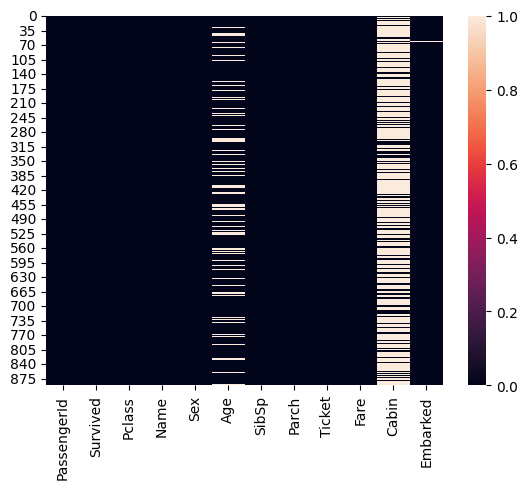

In [5]:
# Heatmap for the analysis of the Missing values
sns.heatmap(train_df.isnull())

In [6]:
# Data types distribution
print("📈 Data Types Distribution:")
dtype_counts = train_df.dtypes.value_counts().reset_index()
dtype_counts.columns = ['Data Type', 'Count']
display(dtype_counts)

📈 Data Types Distribution:


,Data Type,Count
0,int64,5
1,object,5
2,float64,2


<Figure size 600x400 with 0 Axes>

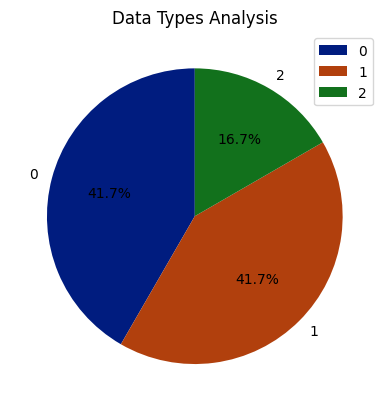

In [7]:
# Pass figsize as a tuple (width, height)
plt.figure(figsize=(6, 4))
dtype_counts.plot(kind='pie', y='Count', autopct='%1.1f%%', startangle=90,colors=sns.color_palette('dark'))
plt.title('Data Types Analysis')
plt.ylabel('')
plt.show()

In [8]:
# Unique values analysis
print("🎯 Unique Values Analysis:")
unique_stats = pd.DataFrame({
'Unique Values': train_df.nunique(),
'Sample Values': [train_df[col].unique()[:20] for col in train_df.columns]
})
display(unique_stats.sort_values('Unique Values', ascending=False).head(10))

🎯 Unique Values Analysis:


,Unique Values,Sample Values
PassengerId,891,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
Name,891,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
Ticket,681,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803..."
Fare,248,"[7.25, 71.2833, 7.925, 53.1, 8.05, 8.4583, 51...."
Cabin,147,"[nan, C85, C123, E46, G6, C103, D56, A6, C23 C..."
Age,88,"[22.0, 38.0, 26.0, 35.0, nan, 54.0, 2.0, 27.0,..."
SibSp,7,"[1, 0, 3, 4, 2, 5, 8]"
Parch,7,"[0, 1, 2, 5, 3, 4, 6]"
Embarked,3,"[S, C, Q, nan]"
Pclass,3,"[3, 1, 2]"


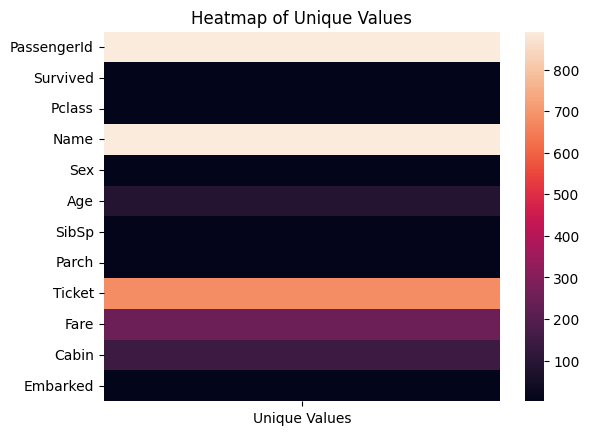

In [9]:
# Heatmap for the analysis of Unique Values
sns.heatmap(unique_stats[['Unique Values']])
plt.title('Heatmap of Unique Values')
plt.show()

In [10]:
# Checking Duplicate
duplicate_values = train_df.duplicated().mean() * 100
print(f'Percentage of Duplicate Values: {duplicate_values}')

Percentage of Duplicate Values: 0.0


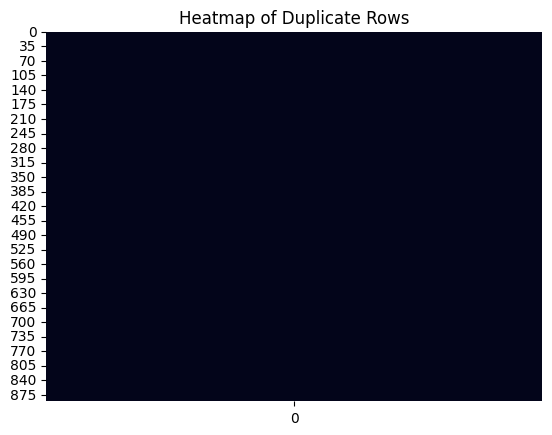

In [11]:
# Visualizing the Duplicate Values
duplicate_mask = train_df.duplicated(keep=False).to_frame()
# Visualizing the Duplicate Values
sns.heatmap(duplicate_mask, cbar=False)
plt.title('Heatmap of Duplicate Rows')
plt.show()

In [12]:
# Checking the Columns
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
# Overview of the whole data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
# Statistical Overview of Data
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [15]:
# Numerical columns
num_cols = train_df.select_dtypes(include=['int64', 'float64'])
num_cols.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

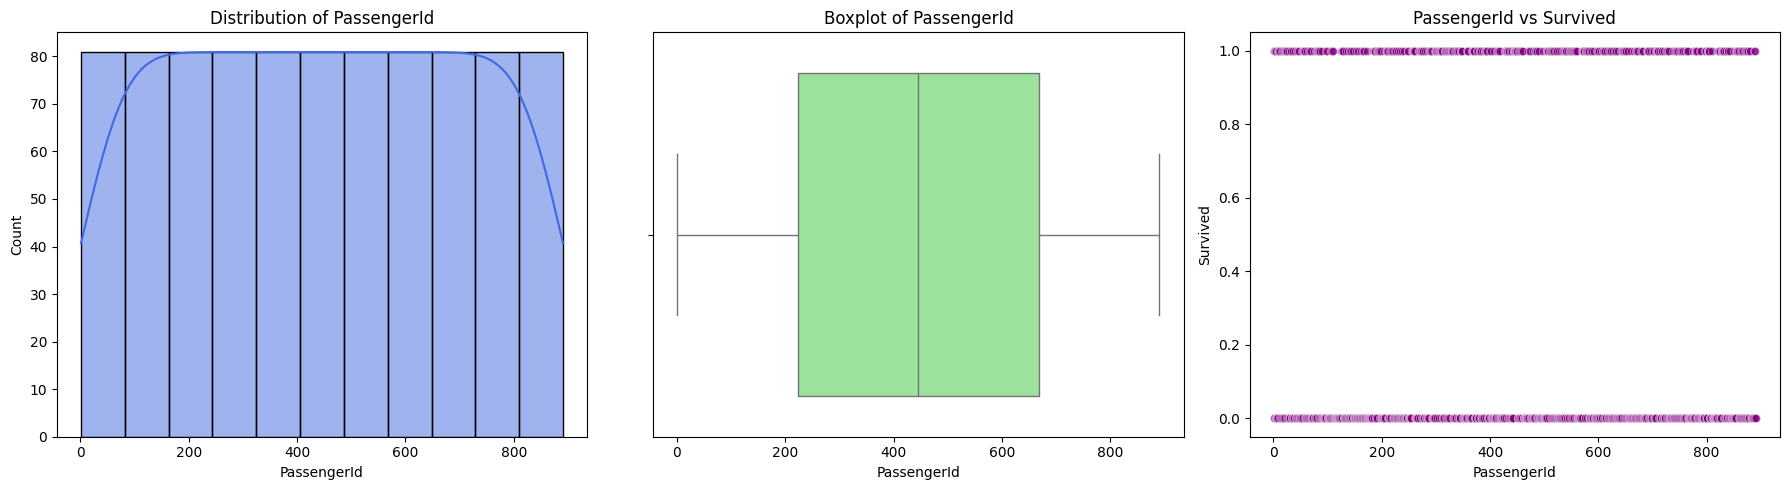


PASSENGERID - DESCRIPTIVE STATISTICS:


,count,mean,std,min,25%,50%,75%,max,range,cv
PassengerId,891.0,446.0,257.353842,1.0,223.5,446.0,668.5,891.0,890.0,0.577027



Pearson Correlation with Survived: -0.01
IQR Outliers: 0 (0.0%)

Missing Values: 0 (0.0%)
Zero Values: 0 (0.0%)


📊 NUMERICAL COLUMN ANALYSIS: PASSENGERID
count    891.000000
mean     446.000000
std      257.353842
min        1.000000
1%         9.900000
5%        45.500000
25%      223.500000
50%      446.000000
75%      668.500000
95%      846.500000
99%      882.100000
max      891.000000

🔍 ADDITIONAL STATISTICS:
• Skewness: 0.0000 (fairly symmetrical)
• Kurtosis: -1.2000 (platykurtic)
• Missing values: 0 (0.00%)
• Unique values: 891
• Zero variance: No

⚠️ OUTLIER DETECTION (IQR METHOD):
• Lower bound: -444.0000
• Upper bound: 1336.0000
• Potential outliers: 0 (0.00%)



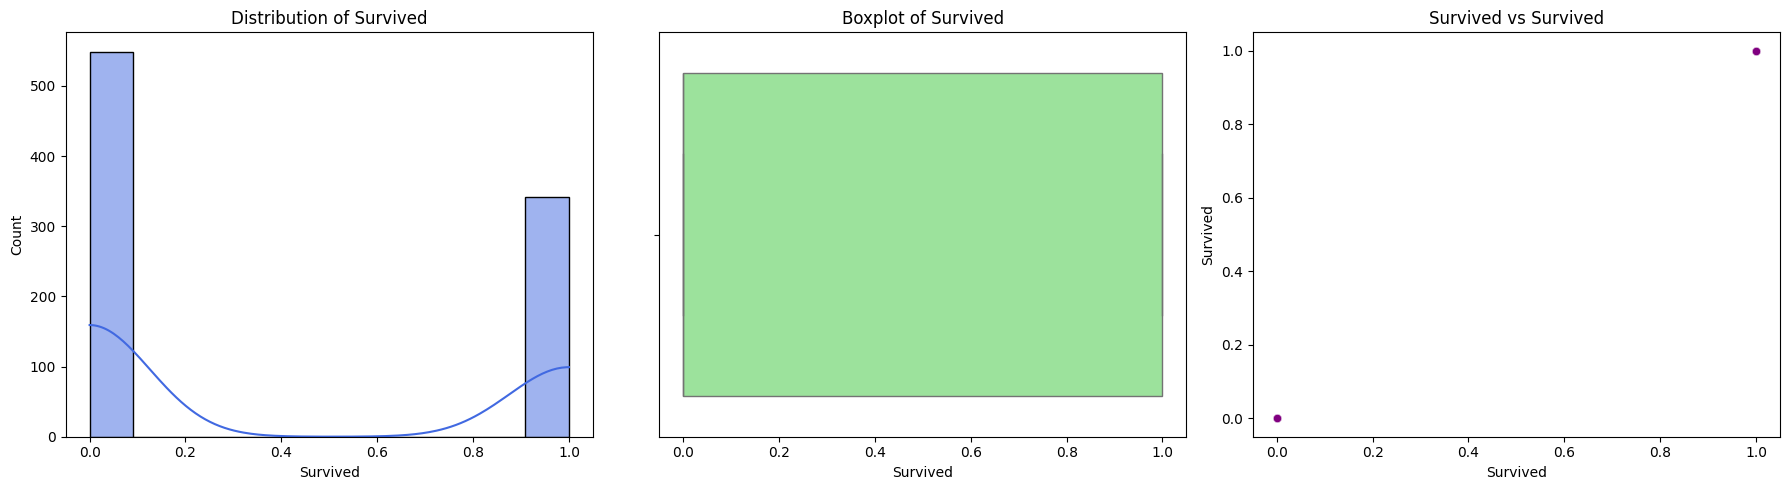


SURVIVED - DESCRIPTIVE STATISTICS:


,count,mean,std,min,25%,50%,75%,max,range,cv
Survived,891.0,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0,1.0,1.267701



Pearson Correlation with Survived: 1.00
IQR Outliers: 0 (0.0%)

Missing Values: 0 (0.0%)
Zero Values: 549 (61.6%)


📊 NUMERICAL COLUMN ANALYSIS: SURVIVED
count    891.000000
mean       0.383838
std        0.486592
min        0.000000
1%         0.000000
5%         0.000000
25%        0.000000
50%        0.000000
75%        1.000000
95%        1.000000
99%        1.000000
max        1.000000

🔍 ADDITIONAL STATISTICS:
• Skewness: 0.4785 (fairly symmetrical)
• Kurtosis: -1.7750 (platykurtic)
• Missing values: 0 (0.00%)
• Unique values: 2
• Zero variance: No

⚠️ OUTLIER DETECTION (IQR METHOD):
• Lower bound: -1.5000
• Upper bound: 2.5000
• Potential outliers: 0 (0.00%)



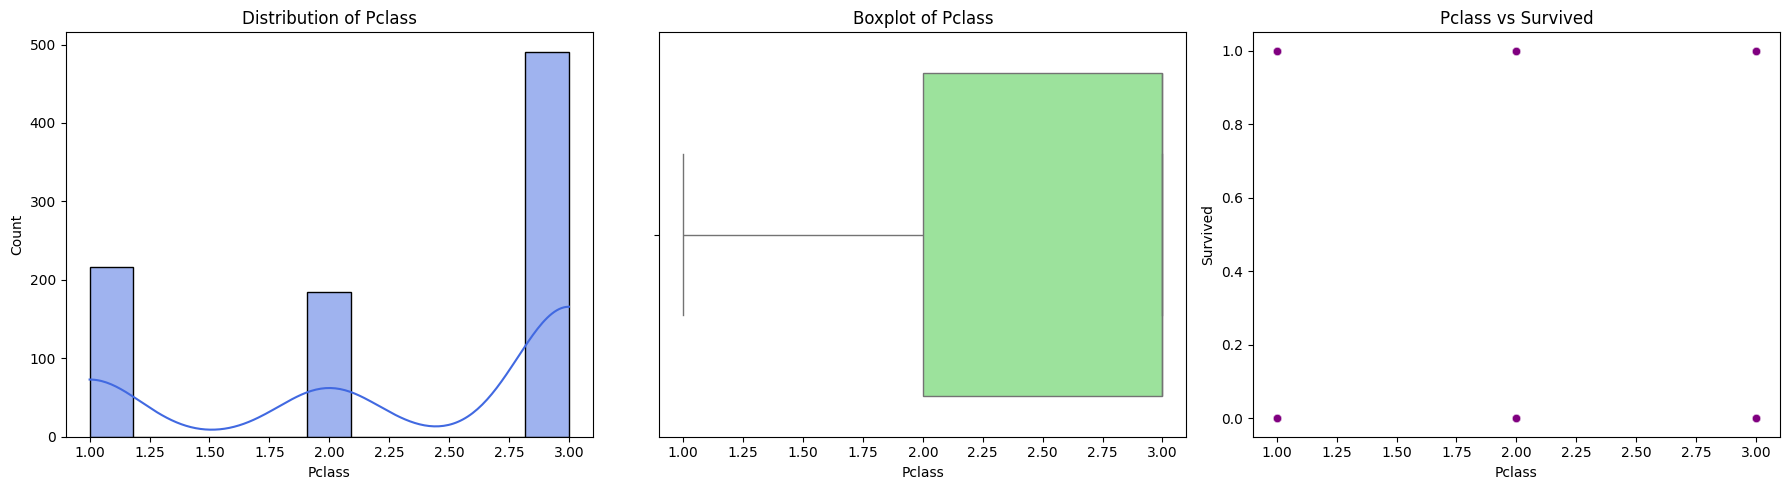


PCLASS - DESCRIPTIVE STATISTICS:


,count,mean,std,min,25%,50%,75%,max,range,cv
Pclass,891.0,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0,2.0,0.362149



Pearson Correlation with Survived: -0.34
IQR Outliers: 0 (0.0%)

Missing Values: 0 (0.0%)
Zero Values: 0 (0.0%)


📊 NUMERICAL COLUMN ANALYSIS: PCLASS
count    891.000000
mean       2.308642
std        0.836071
min        1.000000
1%         1.000000
5%         1.000000
25%        2.000000
50%        3.000000
75%        3.000000
95%        3.000000
99%        3.000000
max        3.000000

🔍 ADDITIONAL STATISTICS:
• Skewness: -0.6305 (moderate)
• Kurtosis: -1.2800 (platykurtic)
• Missing values: 0 (0.00%)
• Unique values: 3
• Zero variance: No

⚠️ OUTLIER DETECTION (IQR METHOD):
• Lower bound: 0.5000
• Upper bound: 4.5000
• Potential outliers: 0 (0.00%)



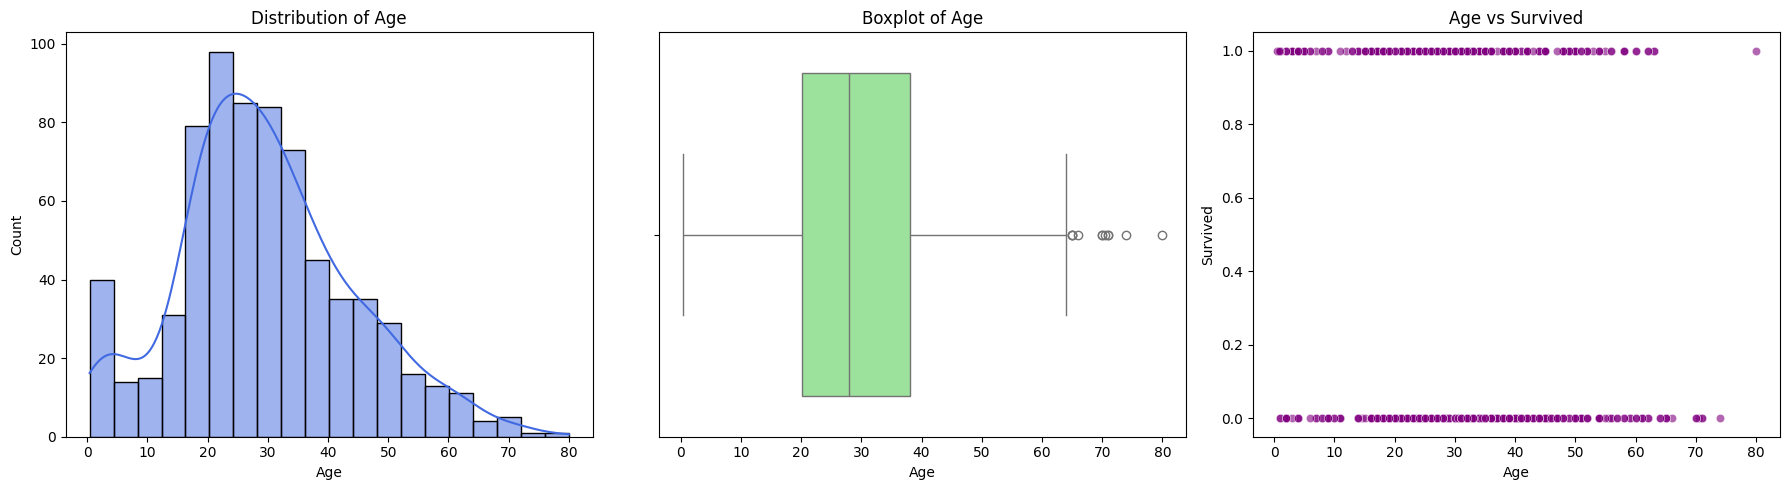


AGE - DESCRIPTIVE STATISTICS:


,count,mean,std,min,25%,50%,75%,max,range,cv
Age,714.0,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0,79.58,0.489122



Pearson Correlation with Survived: -0.08
IQR Outliers: 11 (1.2%)

Missing Values: 177 (19.9%)
Zero Values: 0 (0.0%)


📊 NUMERICAL COLUMN ANALYSIS: AGE
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
1%         1.000000
5%         4.000000
25%       20.125000
50%       28.000000
75%       38.000000
95%       56.000000
99%       65.870000
max       80.000000

🔍 ADDITIONAL STATISTICS:
• Skewness: 0.3891 (fairly symmetrical)
• Kurtosis: 0.1783 (platykurtic)
• Missing values: 177 (19.87%)
• Unique values: 88
• Zero variance: No

⚠️ OUTLIER DETECTION (IQR METHOD):
• Lower bound: -6.6875
• Upper bound: 64.8125
• Potential outliers: 11 (1.23%)
• Min outlier value: 65.0000
• Max outlier value: 80.0000



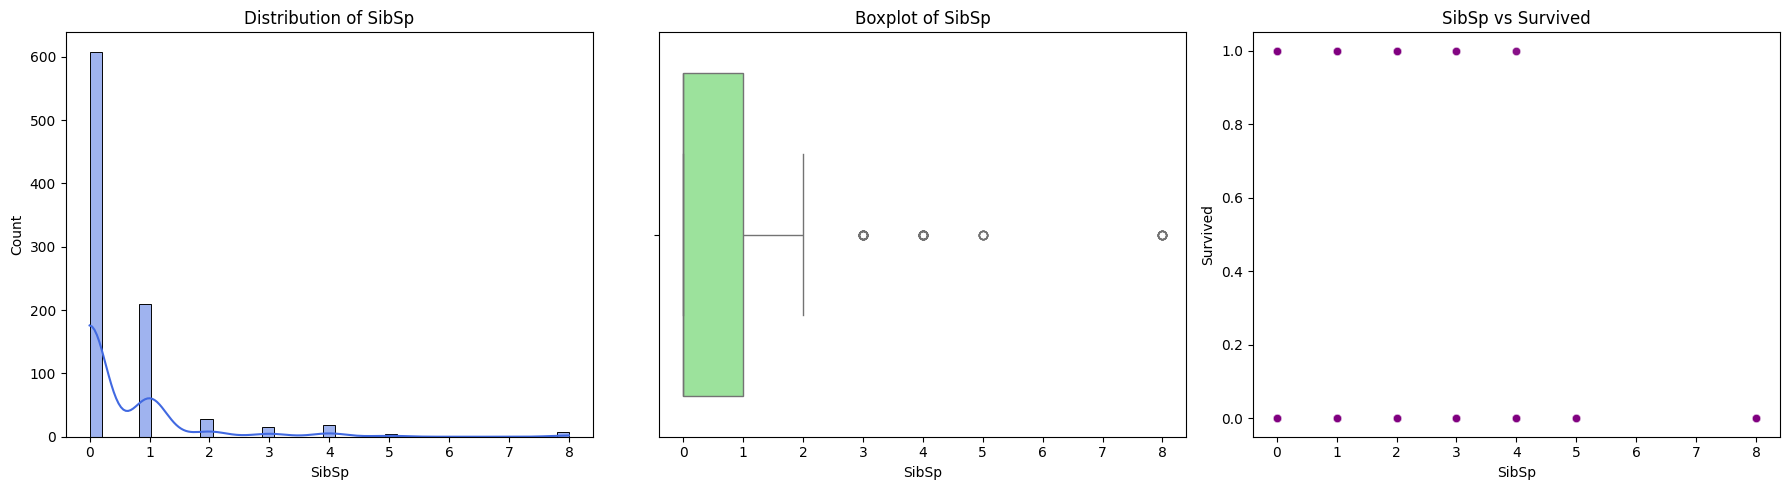


SIBSP - DESCRIPTIVE STATISTICS:


,count,mean,std,min,25%,50%,75%,max,range,cv
SibSp,891.0,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0,8.0,2.108464



Pearson Correlation with Survived: -0.04
IQR Outliers: 46 (5.2%)

Missing Values: 0 (0.0%)
Zero Values: 608 (68.2%)


📊 NUMERICAL COLUMN ANALYSIS: SIBSP
count    891.000000
mean       0.523008
std        1.102743
min        0.000000
1%         0.000000
5%         0.000000
25%        0.000000
50%        0.000000
75%        1.000000
95%        3.000000
99%        5.000000
max        8.000000

🔍 ADDITIONAL STATISTICS:
• Skewness: 3.6954 (strong)
• Kurtosis: 17.8804 (leptokurtic)
• Missing values: 0 (0.00%)
• Unique values: 7
• Zero variance: No

⚠️ OUTLIER DETECTION (IQR METHOD):
• Lower bound: -1.5000
• Upper bound: 2.5000
• Potential outliers: 46 (5.16%)
• Min outlier value: 3.0000
• Max outlier value: 8.0000



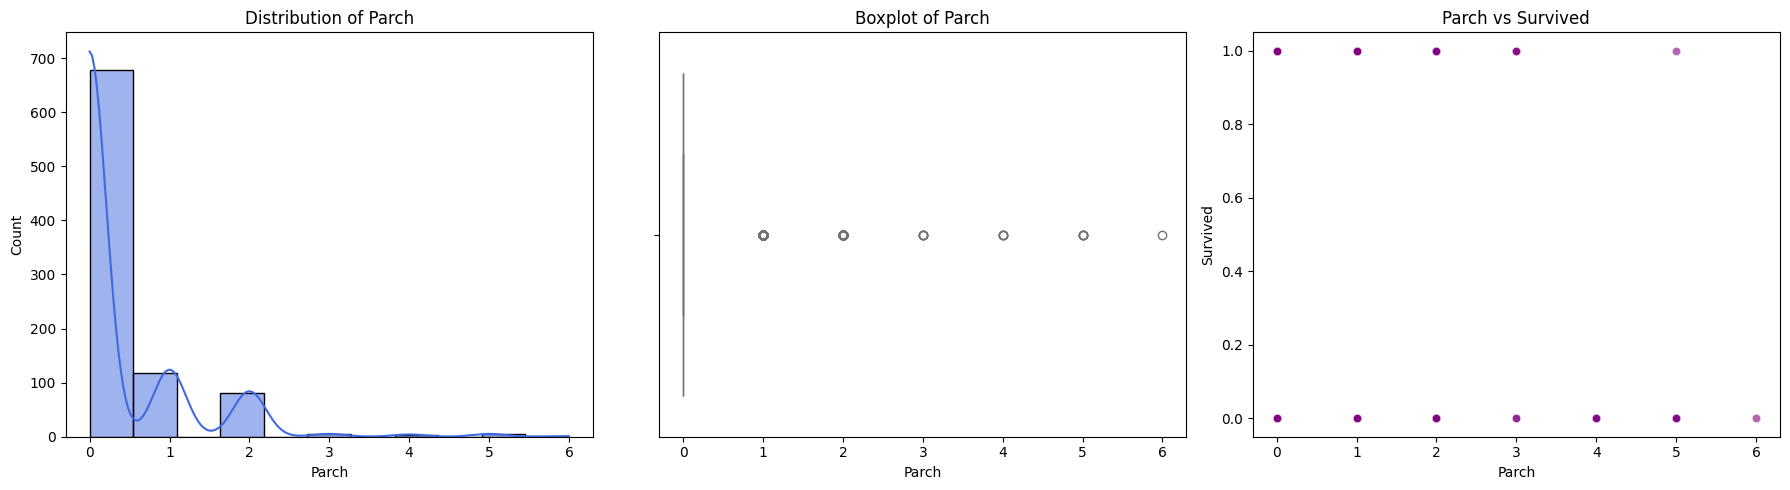


PARCH - DESCRIPTIVE STATISTICS:


,count,mean,std,min,25%,50%,75%,max,range,cv
Parch,891.0,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0,6.0,2.112344



Pearson Correlation with Survived: 0.08
IQR Outliers: 213 (23.9%)

Missing Values: 0 (0.0%)
Zero Values: 678 (76.1%)


📊 NUMERICAL COLUMN ANALYSIS: PARCH
count    891.000000
mean       0.381594
std        0.806057
min        0.000000
1%         0.000000
5%         0.000000
25%        0.000000
50%        0.000000
75%        0.000000
95%        2.000000
99%        4.000000
max        6.000000

🔍 ADDITIONAL STATISTICS:
• Skewness: 2.7491 (strong)
• Kurtosis: 9.7781 (leptokurtic)
• Missing values: 0 (0.00%)
• Unique values: 7
• Zero variance: No

⚠️ OUTLIER DETECTION (IQR METHOD):
• Lower bound: 0.0000
• Upper bound: 0.0000
• Potential outliers: 213 (23.91%)
• Min outlier value: 1.0000
• Max outlier value: 6.0000



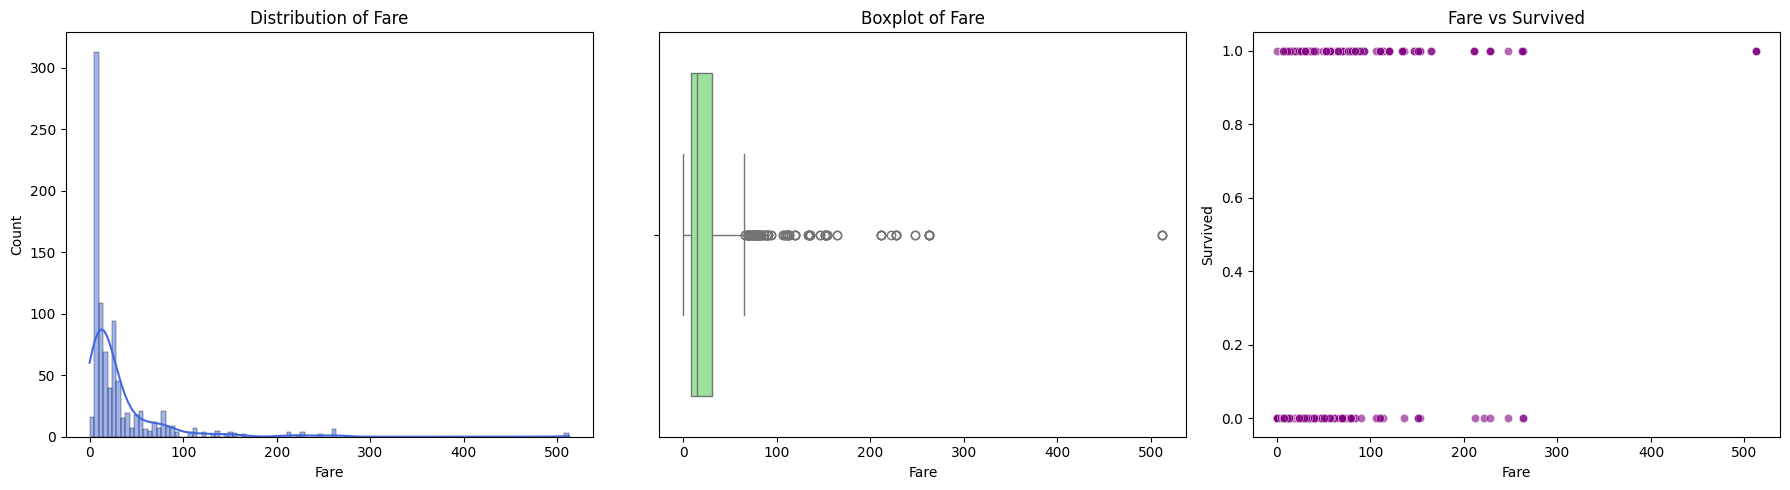


FARE - DESCRIPTIVE STATISTICS:


,count,mean,std,min,25%,50%,75%,max,range,cv
Fare,891.0,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292,512.3292,1.543073



Pearson Correlation with Survived: 0.26
IQR Outliers: 116 (13.0%)

Missing Values: 0 (0.0%)
Zero Values: 15 (1.7%)


📊 NUMERICAL COLUMN ANALYSIS: FARE
count    891.000000
mean      32.204208
std       49.693429
min        0.000000
1%         0.000000
5%         7.225000
25%        7.910400
50%       14.454200
75%       31.000000
95%      112.079150
99%      249.006220
max      512.329200

🔍 ADDITIONAL STATISTICS:
• Skewness: 4.7873 (strong)
• Kurtosis: 33.3981 (leptokurtic)
• Missing values: 0 (0.00%)
• Unique values: 248
• Zero variance: No

⚠️ OUTLIER DETECTION (IQR METHOD):
• Lower bound: -26.7240
• Upper bound: 65.6344
• Potential outliers: 116 (13.02%)
• Min outlier value: 66.6000
• Max outlier value: 512.3292



In [18]:
# Looping over each numerical column for analysis
for col in num_cols:
    # Skip if column has zero variance
    if train_df[col].nunique() == 1:
        print(f"\n⚠️ Column '{col}' has zero variance (constant value: {train_df[col].iloc[0]})")
        continue
    # --- Create figure with 3 subplots ---
    plt.figure(figsize=(18, 5))

    # Subplot 1: Histogram + KDE
    plt.subplot(1, 3, 1)
    sns.histplot(train_df[col].dropna(), color='royalblue', kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)

    # Subplot 2: Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(x=train_df[col].dropna(), color='lightgreen')
    plt.title(f"Boxplot of {col}")

    # Subplot 3: Scatter plot vs target
    plt.subplot(1, 3, 3)
    sns.scatterplot(x=col, y='Survived', data=train_df, alpha=0.6, color='purple')
    plt.title(f"{col} vs Survived")
    plt.ylabel('Survived')

    plt.tight_layout()
    plt.show()

    # --- Descriptive Statistics ---
    stats_df = train_df[col].describe().to_frame().T
    stats_df['range'] = stats_df['max'] - stats_df['min']
    stats_df['cv'] = stats_df['std'] / stats_df['mean']  # Coefficient of variation
    print(f"\n{col.upper()} - DESCRIPTIVE STATISTICS:")
    display(stats_df)

    # --- Correlation with Target ---
    corr = train_df[[col, 'Survived']].corr().iloc[0,1]
    print(f"\nPearson Correlation with Survived: {corr:.2f}")

    # --- Outlier Detection ---
    q1, q3 = np.percentile(train_df[col].dropna(), [25, 75])
    iqr = q3 - q1
    outliers = ((train_df[col] < q1 - 1.5*iqr) | (train_df[col] > q3 + 1.5*iqr)).sum()
    print(f"IQR Outliers: {outliers} ({outliers/len(train_df[col])*100:.1f}%)")

    # --- Data Quality ---
    print(f"\nMissing Values: {train_df[col].isna().sum()} ({train_df[col].isna().mean()*100:.1f}%)")
    print(f"Zero Values: {(train_df[col] == 0).sum()} ({(train_df[col] == 0).mean()*100:.1f}%)\n")

    # Calculate descriptive statistics
    desc_stats = train_df[col].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])

    # Calculate outliers using IQR method
    Q1 = desc_stats['25%']
    Q3 = desc_stats['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)][col]

    # Print comprehensive analysis
    print(f"\n📊 NUMERICAL COLUMN ANALYSIS: {col.upper()}")
    print("="*70)
    print(desc_stats.to_string())

    print("\n🔍 ADDITIONAL STATISTICS:")
    print(f"• Skewness: {train_df[col].skew():.4f} ({'moderate' if 0.5 < abs(train_df[col].skew()) < 1 else 'strong' if abs(train_df[col].skew()) >= 1 else 'fairly symmetrical'})")
    print(f"• Kurtosis: {train_df[col].kurtosis():.4f} ({'leptokurtic' if train_df[col].kurtosis() > 3 else 'platykurtic' if train_df[col].kurtosis() < 3 else 'mesokurtic'})")
    print(f"• Missing values: {train_df[col].isnull().sum()} ({train_df[col].isnull().mean()*100:.2f}%)")
    print(f"• Unique values: {train_df[col].nunique()}")
    print(f"• Zero variance: {'Yes' if train_df[col].nunique() == 1 else 'No'}")

    print("\n⚠️ OUTLIER DETECTION (IQR METHOD):")
    print(f"• Lower bound: {lower_bound:.4f}")
    print(f"• Upper bound: {upper_bound:.4f}")
    print(f"• Potential outliers: {len(outliers)} ({len(outliers)/len(train_df)*100:.2f}%)")
    if len(outliers) > 0:
        print(f"• Min outlier value: {outliers.min():.4f}")
        print(f"• Max outlier value: {outliers.max():.4f}")

    print("="*70 + "\n")

In [20]:
#  Categorical Columns
cat_cols = train_df.select_dtypes(include=['object'])
cat_cols.columns

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

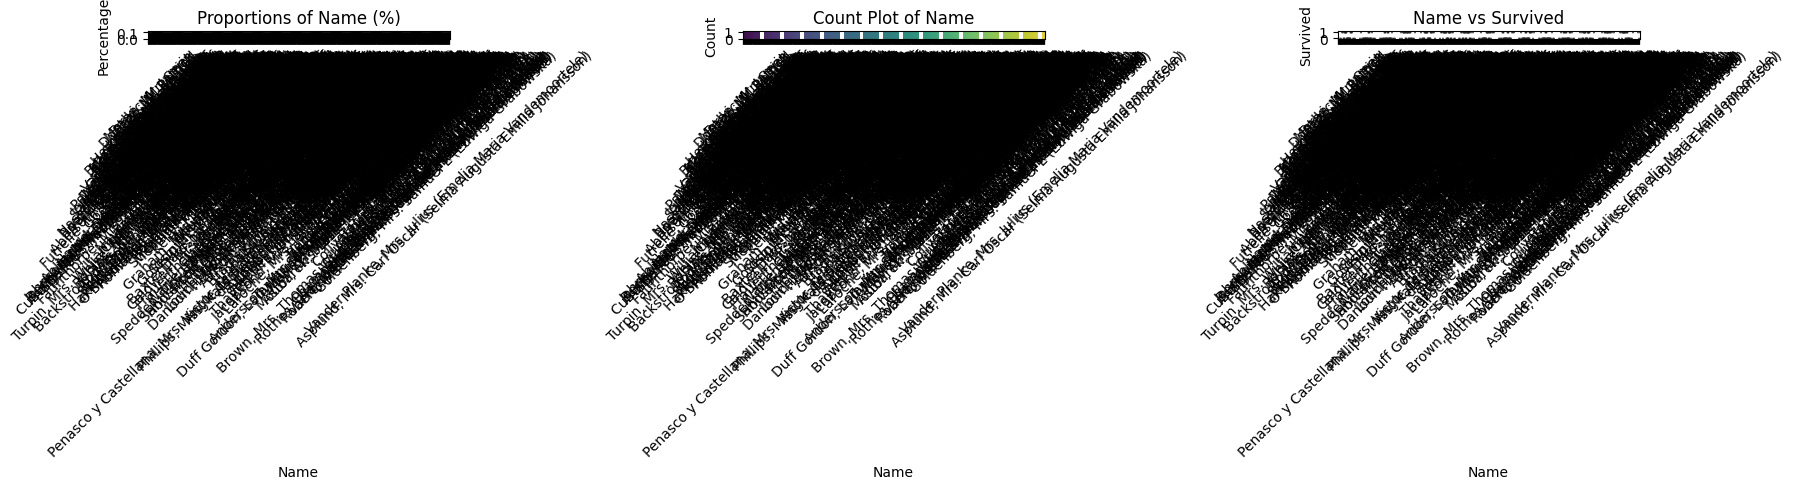


NAME - DESCRIPTIVE STATISTICS:


,count,unique,top,freq,n_unique,mode
Name,891,891,"Dooley, Mr. Patrick",1,891,"Abbing, Mr. Anthony"



Missing Values: 0 (0.0%)

📊 CATEGORICAL COLUMN ANALYSIS: NAME
Total categories: 891
Missing values: 0 (0.00%)

🔍 VALUE COUNTS:
Name
Dooley, Mr. Patrick                                                                   1
Braund, Mr. Owen Harris                                                               1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)                                   1
Heikkinen, Miss. Laina                                                                1
Futrelle, Mrs. Jacques Heath (Lily May Peel)                                          1
Allen, Mr. William Henry                                                              1
Moran, Mr. James                                                                      1
McCarthy, Mr. Timothy J                                                               1
Palsson, Master. Gosta Leonard                                                        1
Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)                          

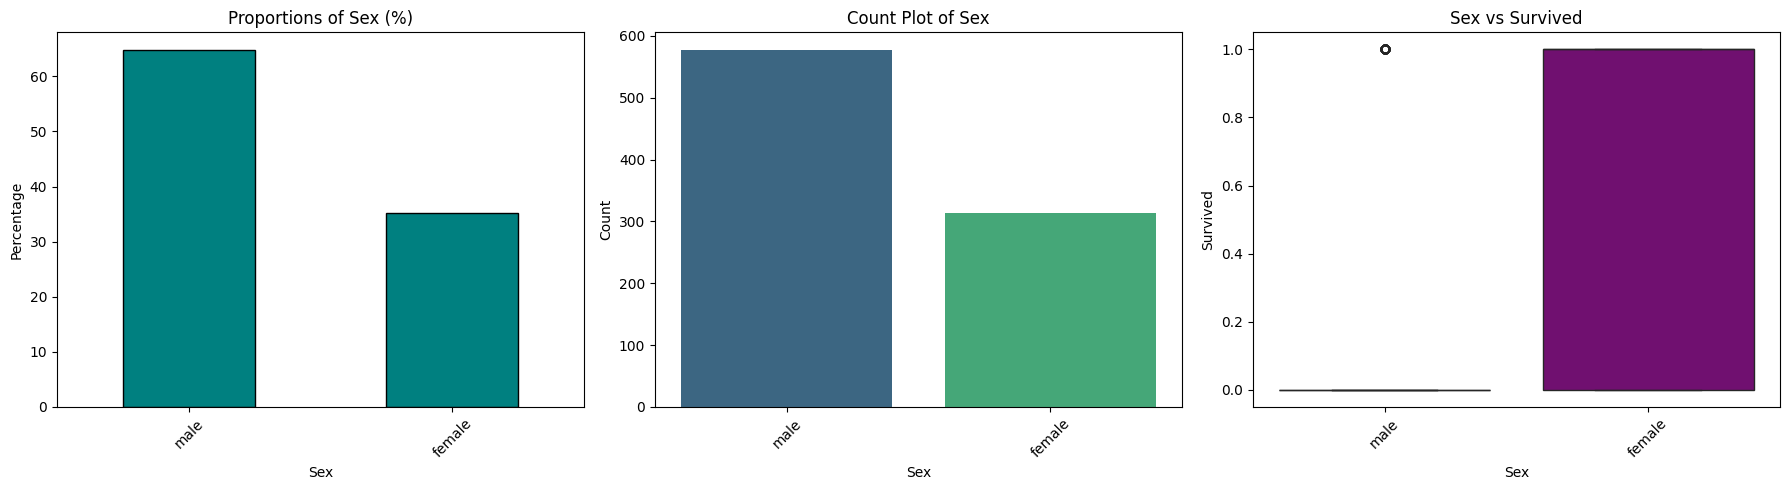


SEX - DESCRIPTIVE STATISTICS:


,count,unique,top,freq,n_unique,mode
Sex,891,2,male,577,2,male



Missing Values: 0 (0.0%)

📊 CATEGORICAL COLUMN ANALYSIS: SEX
Total categories: 2
Missing values: 0 (0.00%)

🔍 VALUE COUNTS:
Sex
male      577
female    314

📈 PERCENTAGE DISTRIBUTION:
Sex
male      64.76
female    35.24

⚠️ CARDINALITY ANALYSIS:
• High cardinality: No

⚖️ BALANCE ANALYSIS:
• Most common category: male (64.76%)
• Least common category: 314.00%)
• Imbalance ratio: 1.8x



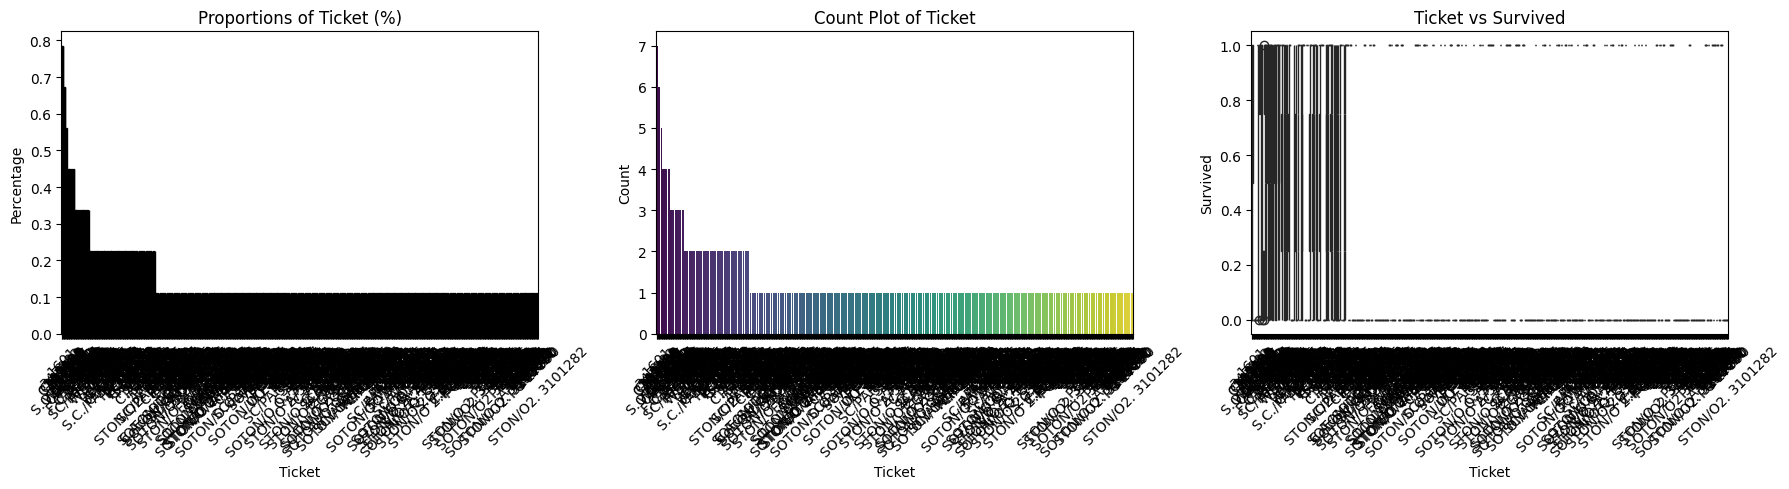


TICKET - DESCRIPTIVE STATISTICS:


,count,unique,top,freq,n_unique,mode
Ticket,891,681,347082,7,681,1601



Missing Values: 0 (0.0%)

📊 CATEGORICAL COLUMN ANALYSIS: TICKET
Total categories: 681
Missing values: 0 (0.00%)

🔍 VALUE COUNTS:
Ticket
347082                7
1601                  7
CA. 2343              7
3101295               6
CA 2144               6
347088                6
382652                5
S.O.C. 14879          5
113760                4
19950                 4
349909                4
347077                4
4133                  4
2666                  4
113781                4
17421                 4
W./C. 6608            4
LINE                  4
PC 17757              4
363291                3
347742                3
C.A. 31921            3
239853                3
13502                 3
PC 17760              3
PC 17582              3
F.C.C. 13529          3
110152                3
110413                3
PC 17755              3
371110                3
PC 17572              3
24160                 3
SC/Paris 2123         3
248727                3
C.A. 34651            3

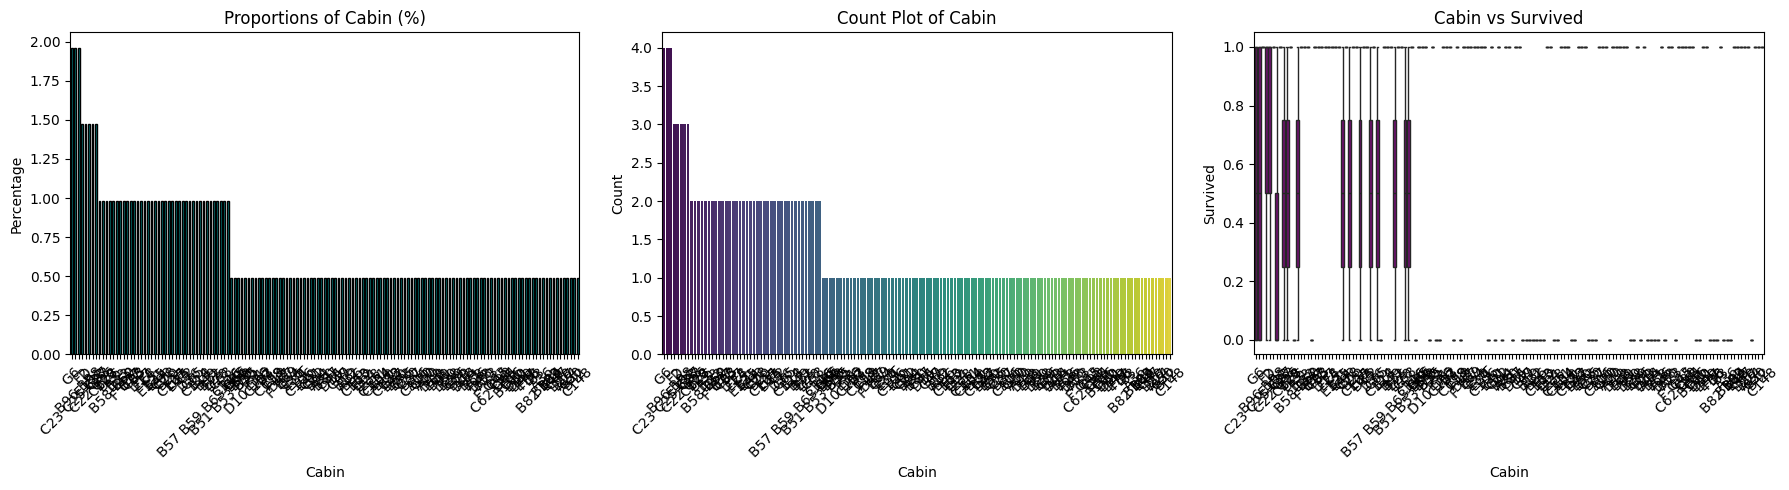


CABIN - DESCRIPTIVE STATISTICS:


,count,unique,top,freq,n_unique,mode
Cabin,204,147,G6,4,147,B96 B98



Missing Values: 687 (77.1%)

📊 CATEGORICAL COLUMN ANALYSIS: CABIN
Total categories: 147
Missing values: 687 (77.10%)

🔍 VALUE COUNTS:
Cabin
G6                 4
C23 C25 C27        4
B96 B98            4
F2                 3
D                  3
E101               3
C22 C26            3
F33                3
C83                2
C123               2
B28                2
D26                2
B58 B60            2
E33                2
D33                2
C52                2
F G73              2
B77                2
C93                2
B5                 2
D17                2
E24                2
E8                 2
E121               2
B35                2
E44                2
C92                2
C78                2
B20                2
C125               2
E67                2
D35                2
F4                 2
C2                 2
D36                2
C65                2
C124               2
B18                2
B57 B59 B63 B66    2
B49                2
B22                

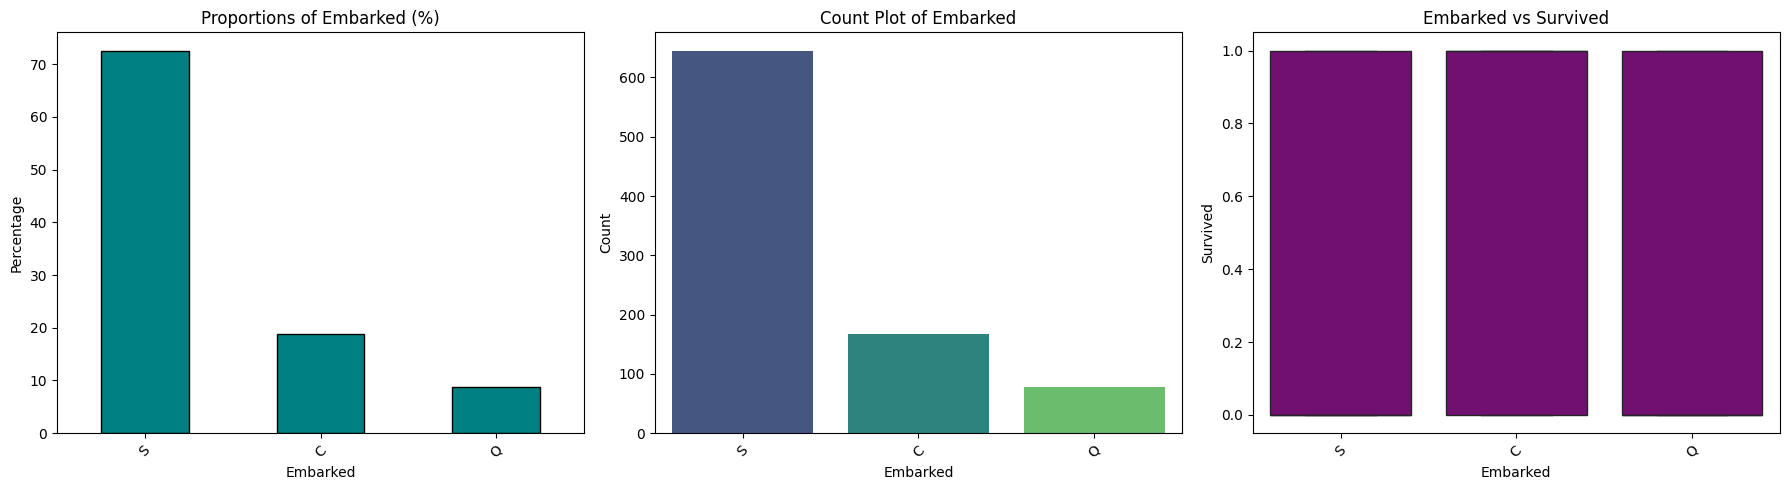


EMBARKED - DESCRIPTIVE STATISTICS:


,count,unique,top,freq,n_unique,mode
Embarked,889,3,S,644,3,S



Missing Values: 2 (0.2%)

📊 CATEGORICAL COLUMN ANALYSIS: EMBARKED
Total categories: 3
Missing values: 2 (0.22%)

🔍 VALUE COUNTS:
Embarked
S    644
C    168
Q     77

📈 PERCENTAGE DISTRIBUTION:
Embarked
S    72.44
C    18.90
Q     8.66

⚠️ CARDINALITY ANALYSIS:
• High cardinality: No

⚖️ BALANCE ANALYSIS:
• Most common category: S (72.44%)
• Least common category: 77.00%)
• Imbalance ratio: 8.4x



In [23]:
from scipy.stats import chi2_contingency

# Looping over each categorical column for analysis
for col in cat_cols:
    # Skip if column has only one unique value
    if train_df[col].nunique() == 1:
        print(f"\n⚠️ Column '{col}' has only one unique value: {train_df[col].iloc[0]}")
        continue

    # --- Create a figure with three subplots ---
    plt.figure(figsize=(18, 5))

    # Subplot 1: Bar Plot (Proportions)
    plt.subplot(1, 3, 1)
    proportions = train_df[col].value_counts(normalize=True) * 100
    proportions.plot(kind='bar', color='teal', edgecolor='black')
    plt.title(f"Proportions of {col} (%)")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.xticks(rotation=45)

    # Subplot 2: Count Plot (Absolute Frequencies)
    plt.subplot(1, 3, 2)
    sns.countplot(x=train_df[col], order=train_df[col].value_counts().index, palette='viridis')
    plt.title(f"Count Plot of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)

    # Subplot 3: Box Plot (Category vs SalePrice)
    plt.subplot(1, 3, 3)
    sns.boxplot(x=train_df[col], y=train_df['Survived'], order=train_df[col].value_counts().index, color='purple')
    plt.title(f"{col} vs Survived")
    plt.xlabel(col)
    plt.ylabel("Survived")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # --- Descriptive Statistics ---
    stats_df = train_df[col].describe().to_frame().T
    stats_df['n_unique'] = train_df[col].nunique()
    stats_df['mode'] = train_df[col].mode().iloc[0]  # Most frequent category
    print(f"\n{col.upper()} - DESCRIPTIVE STATISTICS:")
    display(stats_df)

    # --- Data Quality Checks ---
    na_count = train_df[col].isna().sum()
    print(f"\nMissing Values: {na_count} ({na_count / len(train_df[col]) * 100:.1f}%)")
    # Calculate descriptive statistics
    value_counts = train_df[col].value_counts()
    value_counts_pct = train_df[col].value_counts(normalize=True)*100

    # Print comprehensive analysis
    print(f"\n📊 CATEGORICAL COLUMN ANALYSIS: {col.upper()}")
    print("="*70)
    print(f"Total categories: {train_df[col].nunique()}")
    print(f"Missing values: {train_df[col].isnull().sum()} ({train_df[col].isnull().mean()*100:.2f}%)")

    print("\n🔍 VALUE COUNTS:")
    print(value_counts.to_string())

    print("\n📈 PERCENTAGE DISTRIBUTION:")
    print(value_counts_pct.round(2).to_string())

    # Calculate cardinality and rare categories
    print("\n⚠️ CARDINALITY ANALYSIS:")
    print(f"• High cardinality: {'Yes' if train_df[col].nunique() > 20 else 'No'}")

    # Check for rare categories (less than 1% of data)
    rare_categories = value_counts_pct[value_counts_pct < 1]
    if len(rare_categories) > 0:
        print(f"• Rare categories (<1%): {len(rare_categories)}")
        print("  Rare categories and their percentages:")
        print(rare_categories.round(2).to_string())

    # Check for imbalanced distribution
    max_pct = value_counts_pct.max()
    min_pct = value_counts_pct.min()
    print(f"\n⚖️ BALANCE ANALYSIS:")
    print(f"• Most common category: {value_counts.idxmax()} ({max_pct:.2f}%)")
    print(f"• Least common category: {value_counts.min():.2f}%)")
    print(f"• Imbalance ratio: {max_pct/min_pct:.1f}x")

    print("="*70 + "\n")

In [25]:
train_df.groupby(['Pclass'], as_index=False)['Survived'].mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [26]:
train_df.groupby(['Sex'], as_index=False)['Survived'].mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [27]:
train_df.groupby(['SibSp'], as_index=False)['Survived'].mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [28]:
train_df.groupby(['Parch'], as_index=False)['Survived'].mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [29]:
train_df['Family_Size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Family_Size'] = test_df['SibSp'] + test_df['Parch'] + 1

In [30]:
train_df.groupby(['Family_Size'], as_index=False)['Survived'].mean()

,Family_Size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [31]:
def group_family_size(size):
    if size == 1:
        return 'Alone'
    elif size in [2, 3, 4]:
        return 'Small'
    elif size in [5, 6]:
        return 'Medium'
    elif size >= 7:
        return 'Large'
    else:
        return 'Unknown'

train_df['Family_Size_Grouped'] = train_df['Family_Size'].apply(group_family_size)
test_df['Family_Size_Grouped'] = test_df['Family_Size'].apply(group_family_size)

In [32]:
train_df.groupby(['Family_Size_Grouped'], as_index=False)['Survived'].mean()

,Family_Size_Grouped,Survived
0,Alone,0.303538
1,Large,0.160000
2,Medium,0.162162
3,Small,0.578767


In [33]:
train_df.groupby(['Embarked'], as_index=False)['Survived'].mean()

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


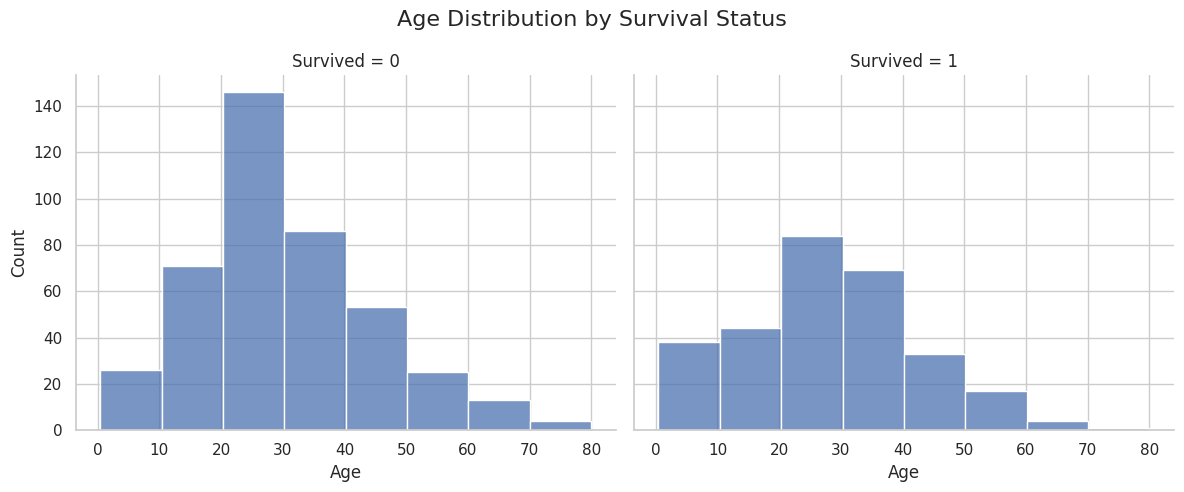

In [34]:
# Set seaborn style for better visuals
sns.set(style="whitegrid")

# Improved displot with different colors for each 'Survived' column
sns.displot(
    data=train_df,
    x='Age',
    col='Survived',
    binwidth=10,
    height=5,
    aspect=1.2,
    color=None,  # We’ll control it via palette
    palette={0: '#FF6F61', 1: '#6B8E23'}  # Red-ish for non-survivors, green-ish for survivors
)

# Optional: Add axis titles
plt.subplots_adjust(top=0.85)
plt.suptitle("Age Distribution by Survival Status", fontsize=16)

plt.show()

In [35]:
train_df['Age_Cut'] = pd.qcut(train_df['Age'], 5)
test_df['Age_Cut'] = pd.qcut(test_df['Age'], 5)

In [36]:
train_df.groupby(['Age_Cut'], as_index=False)['Survived'].mean()

,Age_Cut,Survived
0,"(0.419, 19.0]",0.481707
1,"(19.0, 25.0]",0.328467
2,"(25.0, 31.8]",0.393701
3,"(31.8, 41.0]",0.437500
4,"(41.0, 80.0]",0.373239


In [37]:
age_bins = [-float('inf'), 19, 25, 31.8, 41, 80, float('inf')]
age_labels = [0, 1, 2, 3, 4, 4] # Contains duplicate label 4

for df in [train_df, test_df]:
    # Set ordered=False to allow non-unique labels
    df['Age'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, ordered=False)

In [38]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped,Age_Cut
0,1,0,3,"Braund, Mr. Owen Harris",male,1,1,0,A/5 21171,7.2500,NaN,S,2,Small,"(19.0, 25.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3,1,0,PC 17599,71.2833,C85,C,2,Small,"(31.8, 41.0]"
2,3,1,3,"Heikkinen, Miss. Laina",female,2,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Alone,"(25.0, 31.8]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3,1,0,113803,53.1000,C123,S,2,Small,"(31.8, 41.0]"
4,5,0,3,"Allen, Mr. William Henry",male,3,0,0,373450,8.0500,NaN,S,1,Alone,"(31.8, 41.0]"


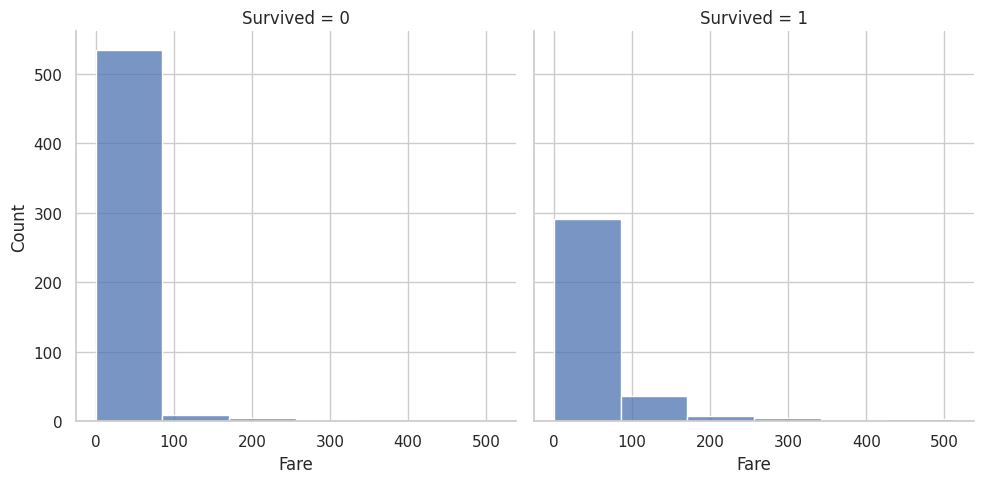

In [39]:
sns.displot(train_df, x='Fare', col='Survived', binwidth=80, height=5)

In [40]:
train_df['Fare_Cut'] = pd.qcut(train_df['Fare'], 5)
test_df['Fare_Cut'] = pd.qcut(test_df['Fare'], 5)

In [41]:
train_df.groupby(['Fare_Cut'], as_index=False)['Survived'].mean()

,Fare_Cut,Survived
0,"(-0.001, 7.854]",0.217877
1,"(7.854, 10.5]",0.201087
2,"(10.5, 21.679]",0.424419
3,"(21.679, 39.688]",0.444444
4,"(39.688, 512.329]",0.642045


In [42]:
def bin_fare(df):
    df.loc[df['Fare'] <= 7.854, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.854) & (df['Fare'] <= 10.5), 'Fare'] = 1
    df.loc[(df['Fare'] > 10.5) & (df['Fare'] <= 21.679), 'Fare'] = 2
    df.loc[(df['Fare'] > 21.679) & (df['Fare'] <= 39.688), 'Fare'] = 3
    df.loc[(df['Fare'] > 39.688), 'Fare'] = 4  # Combined last two cases since they both =4
    return df

train_df = bin_fare(train_df)
test_df = bin_fare(test_df)

In [43]:
train_df['Name']

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,"Heikkinen, Miss. Laina"
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,"Allen, Mr. William Henry"
...,...
886,"Montvila, Rev. Juozas"
887,"Graham, Miss. Margaret Edith"
888,"Johnston, Miss. Catherine Helen ""Carrie"""
889,"Behr, Mr. Karl Howell"


In [44]:
train_df['Title'] = train_df['Name'].str.split(pat= ",", expand=True)[1].str.split(pat= ".", expand=True)[0].apply(lambda x: x.strip())
test_df['Title'] = test_df['Name'].str.split(pat= ",", expand=True)[1].str.split(pat= ".", expand=True)[0].apply(lambda x: x.strip())

In [45]:
train_df.groupby(['Title'], as_index=False)['Survived'].mean()

,Title,Survived
0,Capt,0.000000
1,Col,0.500000
2,Don,0.000000
3,Dr,0.428571
4,Jonkheer,0.000000
5,Lady,1.000000
6,Major,0.500000
7,Master,0.575000
8,Miss,0.697802
9,Mlle,1.000000


In [46]:
# Define title mapping once (DRY principle)
title_mapping = {
    'Capt': 'Military',
    'Col': 'Military',
    'Major': 'Military',
    'Jonkheer': 'Noble',
    'the Countess': 'Noble',
    'Don': 'Noble',
    'Lady': 'Noble',
    'Sir': 'Noble',
    'Mlle': 'Noble',
    'Ms': 'Noble',
    'Mme': 'Noble'
}

# Apply to both DataFrames efficiently
train_df['Title'] = train_df['Title'].replace(title_mapping)
test_df['Title'] = test_df['Title'].replace(title_mapping)

In [47]:
train_df.groupby(['Title'], as_index=False)['Survived'].agg(['count', 'mean'])

,Title,count,mean
0,Dr,7,0.428571
1,Master,40,0.575000
2,Military,5,0.400000
3,Miss,182,0.697802
4,Mr,517,0.156673
5,Mrs,125,0.792000
6,Noble,9,0.777778
7,Rev,6,0.000000


In [48]:
train_df['Name_Length'] = train_df['Name'].apply(lambda x: len(x))
test_df['Name_Length'] = test_df['Name'].apply(lambda x: len(x))

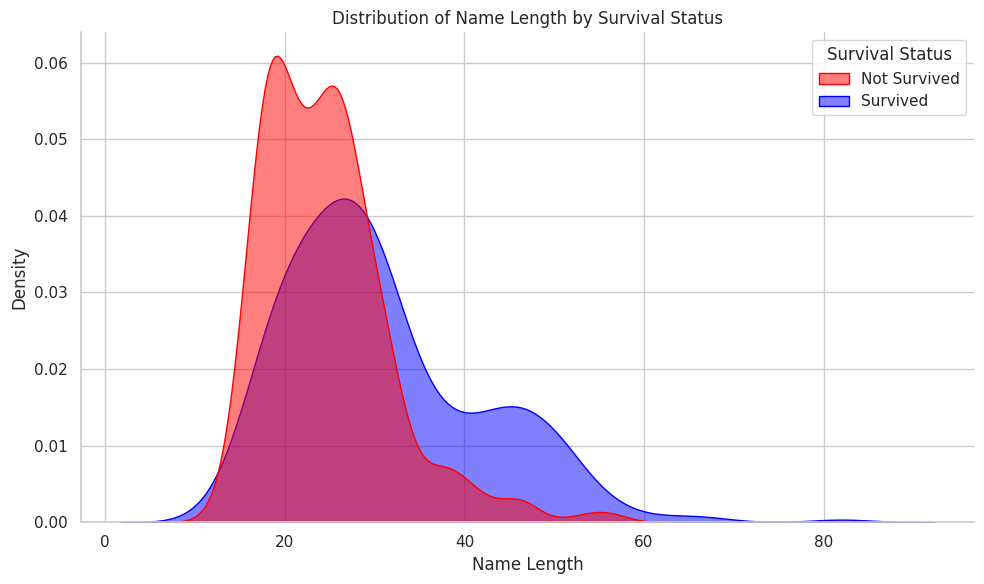

In [49]:
# Create a cleaner and more efficient KDE plot
plt.figure(figsize=(10, 6))
g = sns.kdeplot(
    data=train_df,
    x='Name_Length',
    hue='Survived',
    palette={0: 'red', 1: 'blue'},
    fill=True,
    common_norm=False,  # Shows actual density for each group
    alpha=0.5  # Adds transparency for better visibility
)

# Improve plot aesthetics
g.set(
    xlabel='Name Length',
    ylabel='Density',
    title='Distribution of Name Length by Survival Status'
)
g.legend_.set_title('Survival Status')
g.legend_.get_texts()[0].set_text('Not Survived')
g.legend_.get_texts()[1].set_text('Survived')

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()

In [50]:
train_df['Name_LengthGB'] = pd.qcut(train_df['Name_Length'], 3)
test_df['Name_LengthGB'] = pd.qcut(test_df['Name_Length'], 3)

In [51]:
train_df.groupby(['Name_LengthGB'], as_index=False)['Survived'].mean()

,Name_LengthGB,Survived
0,"(11.999, 22.0]",0.252336
1,"(22.0, 28.0]",0.322581
2,"(28.0, 82.0]",0.587629


In [52]:
# Define bins and labels
name_bins = [-float('inf'), 22, 28, 82, float('inf')]
name_labels = [0, 1, 2, 2]  # Both >28 and >82 get label 2

# Function to bin name lengths
def bin_name_length(df):
    df['Name_Size'] = pd.cut(
        df['Name_Length'],
        bins=name_bins,
        labels=name_labels,
        right=True,
        ordered=False
    ).astype(int)
    return df

# Apply to both dataframes
train_df = bin_name_length(train_df)
test_df = bin_name_length(test_df)

In [53]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped,Age_Cut,Fare_Cut,Title,Name_Length,Name_LengthGB,Name_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,1,1,0,A/5 21171,0.0,NaN,S,2,Small,"(19.0, 25.0]","(-0.001, 7.854]",Mr,23,"(22.0, 28.0]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3,1,0,PC 17599,4.0,C85,C,2,Small,"(31.8, 41.0]","(39.688, 512.329]",Mrs,51,"(28.0, 82.0]",2
2,3,1,3,"Heikkinen, Miss. Laina",female,2,0,0,STON/O2. 3101282,1.0,NaN,S,1,Alone,"(25.0, 31.8]","(7.854, 10.5]",Miss,22,"(11.999, 22.0]",0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3,1,0,113803,4.0,C123,S,2,Small,"(31.8, 41.0]","(39.688, 512.329]",Mrs,44,"(28.0, 82.0]",2
4,5,0,3,"Allen, Mr. William Henry",male,3,0,0,373450,1.0,NaN,S,1,Alone,"(31.8, 41.0]","(7.854, 10.5]",Mr,24,"(22.0, 28.0]",1


In [54]:
train_df['Ticket']

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450
...,...
886,211536
887,112053
888,W./C. 6607
889,111369


In [55]:
train_df['TicketNumber'] = train_df['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))
test_df['TicketNumber'] = test_df['Ticket'].apply(lambda x: pd.Series({'Ticket': x.split()[-1]}))

In [56]:
train_df.groupby(['TicketNumber'], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending=False)

,TicketNumber,count,mean
94,1601,7,0.714286
196,2343,7,0.000000
464,347082,7,0.000000
468,347088,6,0.000000
358,3101295,6,0.000000
...,...,...,...
276,2667,1,1.000000
278,2669,1,0.000000
279,26707,1,0.000000
280,2671,1,0.000000


In [57]:
train_df.groupby('TicketNumber')['TicketNumber'].transform('count')

,TicketNumber
0,1
1,1
2,1
3,2
4,1
...,...
886,1
887,1
888,2
889,1


In [58]:
train_df['TicketNumberCounts'] = train_df.groupby('TicketNumber')['TicketNumber'].transform('count')
test_df['TicketNumberCounts'] = test_df.groupby('TicketNumber')['TicketNumber'].transform('count')

In [59]:
train_df.groupby(['TicketNumberCounts'], as_index=False)['Survived'].agg(['count', 'mean']).sort_values('count', ascending=False)

,TicketNumberCounts,count,mean
0,1,544,0.295956
1,2,188,0.569149
2,3,66,0.712121
3,4,44,0.500000
6,7,21,0.238095
5,6,18,0.000000
4,5,10,0.000000


In [60]:
train_df['Ticket']

,Ticket
0,A/5 21171
1,PC 17599
2,STON/O2. 3101282
3,113803
4,373450
...,...
886,211536
887,112053
888,W./C. 6607
889,111369


In [61]:
train_df['Ticket'].str.split(pat=" ", expand=True)

,0,1,2
0,A/5,21171,None
1,PC,17599,None
2,STON/O2.,3101282,None
3,113803,None,None
4,373450,None,None
...,...,...,...
886,211536,None,None
887,112053,None,None
888,W./C.,6607,None
889,111369,None,None


In [62]:
train_df['TicketLocation'] = np.where(train_df['Ticket'].str.split(pat=" ", expand=True)[1].notna(), train_df['Ticket'].str.split(pat=" ", expand=True)[0].apply(lambda x: x.strip()), 'Blank')
test_df['TicketLocation'] = np.where(test_df['Ticket'].str.split(pat=" ", expand=True)[1].notna(), test_df['Ticket'].str.split(pat=" ", expand=True)[0].apply(lambda x: x.strip()), 'Blank')

In [63]:
train_df['TicketLocation'].value_counts()

,count
TicketLocation,
Blank,665
PC,60
C.A.,27
STON/O,12
A/5,10
W./C.,9
CA.,8
SOTON/O.Q.,8
A/5.,7


In [64]:
# Define standardization mapping once (DRY principle)
ticket_mapping = {
    'SOTON/O.Q.': 'SOTON/OQ',
    'C.A.': 'CA',
    'CA.': 'CA',
    'SC/PARIS': 'SC/Paris',
    'S.C./PARIS': 'SC/Paris',
    'A/4.': 'A/4',
    'A/5.': 'A/5',
    'A.5.': 'A/5',
    'A./5.': 'A/5',
    'W./C.': 'W/C'
}

# Create reusable function for standardization
def standardize_ticket_location(df):
    df['TicketLocation'] = df['TicketLocation'].replace(ticket_mapping)
    return df

# Apply to both DataFrames
train_df = standardize_ticket_location(train_df)
test_df = standardize_ticket_location(test_df)

In [65]:
train_df.groupby(['TicketLocation'], as_index=False)['Survived'].agg(['count', 'mean'])

,TicketLocation,count,mean
0,A/4,6,0.000000
1,A/5,21,0.095238
2,A/S,1,0.000000
3,A4.,1,0.000000
4,Blank,665,0.383459
5,C,5,0.400000
6,C.A./SOTON,1,0.000000
7,CA,41,0.341463
8,F.C.,1,0.000000
9,F.C.C.,5,0.800000


In [66]:
train_df['Cabin'] = train_df['Cabin'].fillna('U')
train_df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'x' for i in train_df['Cabin']])

test_df['Cabin'] = test_df['Cabin'].fillna('U')
test_df['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'x' for i in test_df['Cabin']])

In [67]:
train_df.groupby(['Cabin'], as_index=False)['Survived'].agg(['count', 'mean'])

,Cabin,count,mean
0,A,15,0.466667
1,B,47,0.744681
2,C,59,0.593220
3,D,33,0.757576
4,E,32,0.750000
5,F,13,0.615385
6,G,4,0.500000
7,T,1,0.000000
8,U,687,0.299854


In [68]:
train_df['Cabin_Assigned'] = train_df['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)
test_df['Cabin_Assigned'] = test_df['Cabin'].apply(lambda x: 0 if x in ['U'] else 1)

In [69]:
train_df.groupby(['Cabin_Assigned'], as_index=False)['Survived'].agg(['count', 'mean'])

,Cabin_Assigned,count,mean
0,0,687,0.299854
1,1,204,0.666667


In [70]:
# Featured Data Overview
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_Size,Family_Size_Grouped,Age_Cut,Fare_Cut,Title,Name_Length,Name_LengthGB,Name_Size,TicketNumber,TicketNumberCounts,TicketLocation,Cabin_Assigned
0,1,0,3,"Braund, Mr. Owen Harris",male,1,1,0,A/5 21171,0.0,U,S,2,Small,"(19.0, 25.0]","(-0.001, 7.854]",Mr,23,"(22.0, 28.0]",1,21171,1,A/5,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3,1,0,PC 17599,4.0,C,C,2,Small,"(31.8, 41.0]","(39.688, 512.329]",Mrs,51,"(28.0, 82.0]",2,17599,1,PC,1
2,3,1,3,"Heikkinen, Miss. Laina",female,2,0,0,STON/O2. 3101282,1.0,U,S,1,Alone,"(25.0, 31.8]","(7.854, 10.5]",Miss,22,"(11.999, 22.0]",0,3101282,1,STON/O2.,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3,1,0,113803,4.0,C,S,2,Small,"(31.8, 41.0]","(39.688, 512.329]",Mrs,44,"(28.0, 82.0]",2,113803,2,Blank,1
4,5,0,3,"Allen, Mr. William Henry",male,3,0,0,373450,1.0,U,S,1,Alone,"(31.8, 41.0]","(7.854, 10.5]",Mr,24,"(22.0, 28.0]",1,373450,1,Blank,0


In [71]:
train_df.shape

(891, 24)

In [72]:
test_df.shape

(418, 23)

In [73]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Family_Size',
       'Family_Size_Grouped', 'Age_Cut', 'Fare_Cut', 'Title', 'Name_Length',
       'Name_LengthGB', 'Name_Size', 'TicketNumber', 'TicketNumberCounts',
       'TicketLocation', 'Cabin_Assigned'],
      dtype='object')

In [74]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   PassengerId          418 non-null    int64   
 1   Pclass               418 non-null    int64   
 2   Name                 418 non-null    object  
 3   Sex                  418 non-null    object  
 4   Age                  332 non-null    category
 5   SibSp                418 non-null    int64   
 6   Parch                418 non-null    int64   
 7   Ticket               418 non-null    object  
 8   Fare                 417 non-null    float64 
 9   Cabin                418 non-null    object  
 10  Embarked             418 non-null    object  
 11  Family_Size          418 non-null    int64   
 12  Family_Size_Grouped  418 non-null    object  
 13  Age_Cut              332 non-null    category
 14  Fare_Cut             417 non-null    category
 15  Title                41

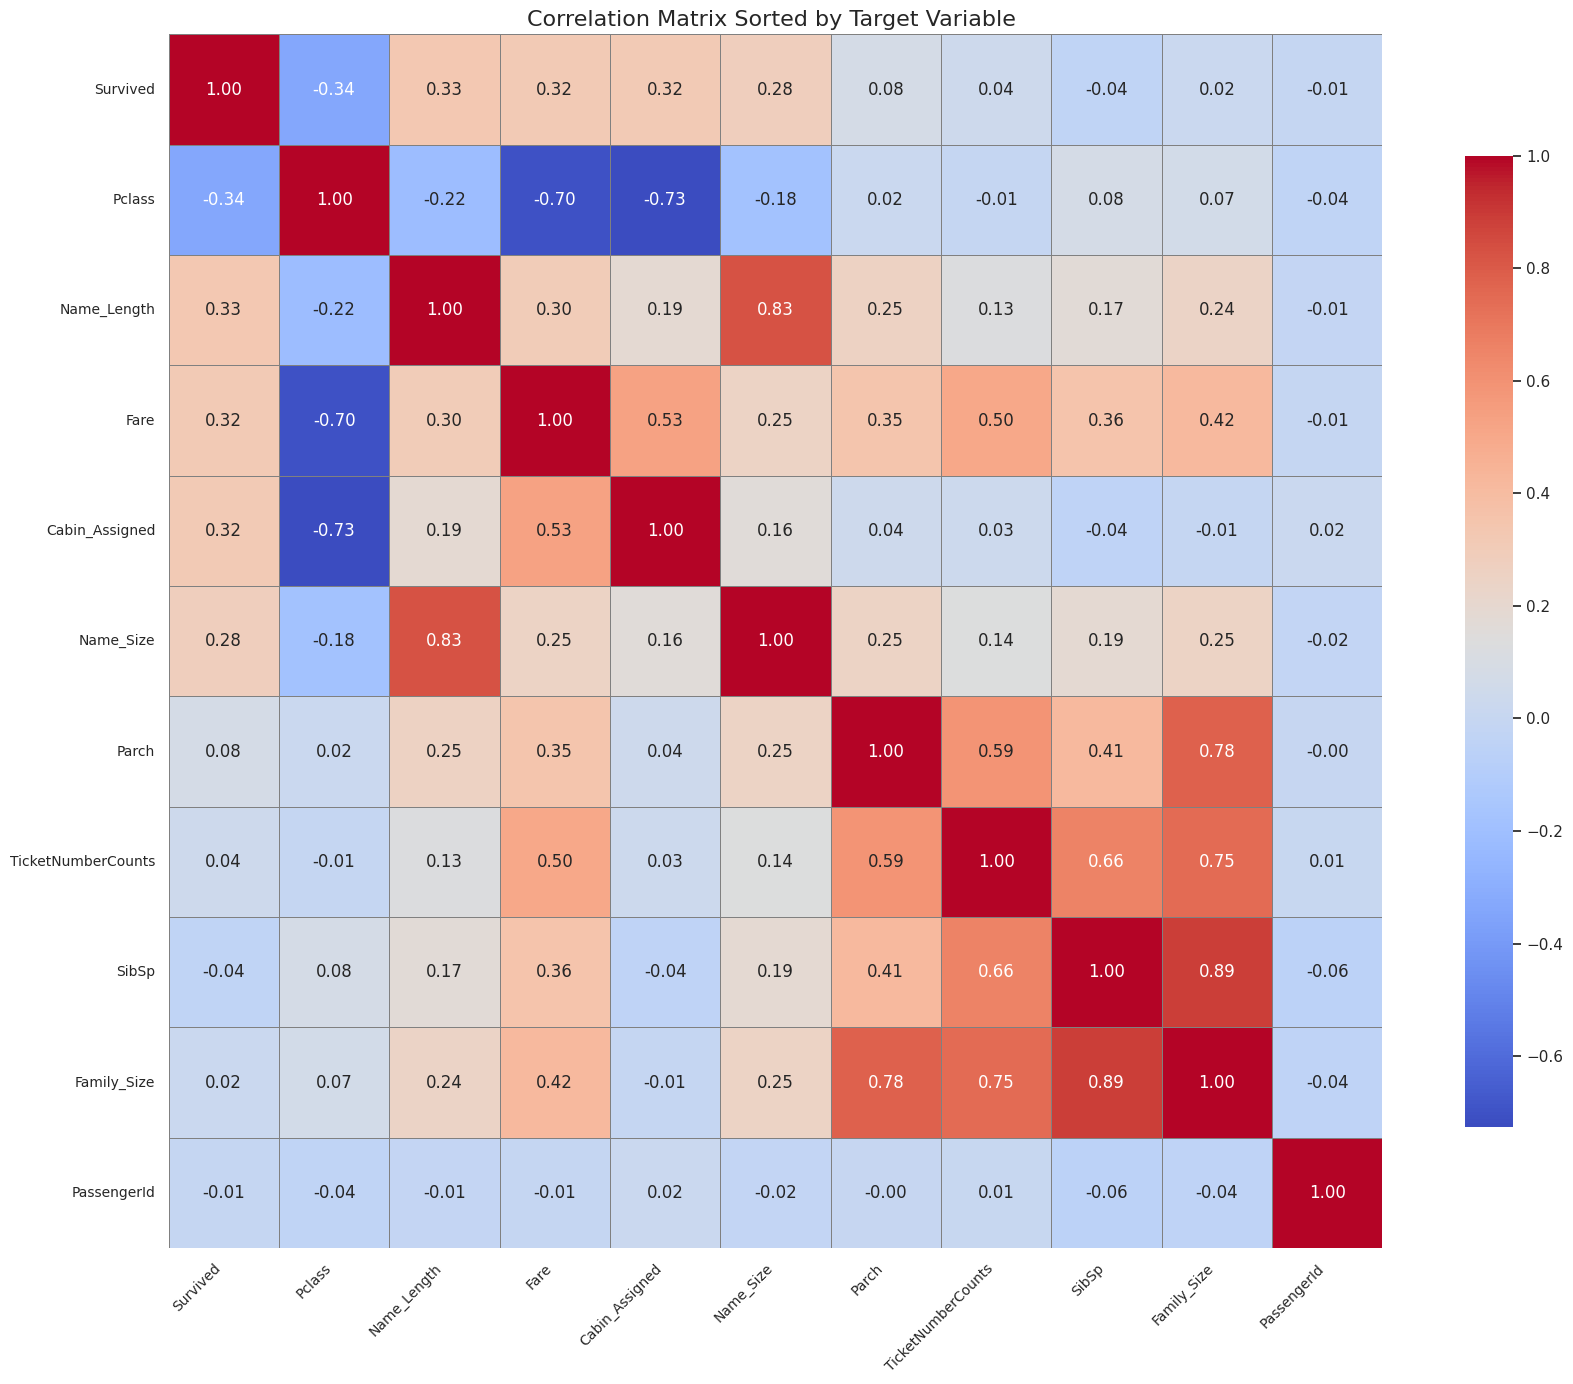

In [75]:
  # Compute correlation matrix (numeric columns only)
corr_matrix = train_df.corr(numeric_only=True)

# Sort correlations by absolute correlation with target ('SalePrice')
target = 'Survived'
sorted_features = corr_matrix[target].abs().sort_values(ascending=False).index
sorted_corr = corr_matrix.loc[sorted_features, sorted_features]

# Set up the matplotlib figure
plt.figure(figsize=(18, 14))
plt.title('Correlation Matrix Sorted by Target Variable ', fontsize=16)

# Draw heatmap with annotations and mask
sns.heatmap(
    sorted_corr,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8},
    square=True
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

In [90]:
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression # Import LogisticRegression

# Define columns for different transformations (restated for clarity as this block is standalone)
NUMERICAL_COLS = ['Age', 'Fare']
ORDINAL_COLS = ['Family_Size_Grouped', 'Pclass']  # Pclass is ordinal despite being numeric
OHE_COLS = ['Sex', 'Embarked', 'Cabin_Assigned']
PASSTHROUGH_COLS = ['Name_Size', 'TicketNumberCounts'] # Keeping these columns as they were created from other columns and should be numeric after binning/counting
TARGET = 'Survived'
# Check if KBinsDiscretizer output needs to be integer for certain downstream models
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    # Use 'uniform' or 'kmeans' strategy with 'ordinal' encode if bins have issues
    # Check if the number of bins (5) is appropriate for the data distribution
    ('discretizer', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile'))
])

ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

ohe_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # Drop one column for binary features to avoid multicollinearity (if_binary)
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary'))
])

# Main column transformer (restated for clarity)
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, NUMERICAL_COLS),
    ('ord', ordinal_pipeline, ORDINAL_COLS),
    ('ohe', ohe_pipeline, OHE_COLS),
    ('pass', 'passthrough', PASSTHROUGH_COLS) # Pass these engineered numerical columns through
], remainder='drop') # Explicitly drop unused columns like 'Name', 'Ticket', 'PassengerId', etc.

# Full pipeline with feature selection and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
    ('classifier', LogisticRegression()) # Add the classifier as the last step
])

In [78]:
# Data preparation
X = train_df.drop(TARGET, axis=1)
y = train_df[TARGET]

x = pipeline.fit_transform(X, y)

In [79]:
# Train-test split with stratification
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=21
)

In [88]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, log_loss)
from sklearn.model_selection import (GridSearchCV, cross_val_score, learning_curve)
from sklearn.base import is_classifier
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def evaluate_model(model, X_train, y_train, X_test, y_test, cv=5,
                  verbose=True, plot_learning_curve=True, plot_residuals=True):
    """
    Comprehensive model evaluation for classification with metrics, cross-validation, and visual diagnostics.

    Parameters:
    - model: sklearn estimator or GridSearchCV/RandomSearchCV object (should be the full pipeline)
    - X_train, y_train: Training data (original, will be preprocessed)
    - X_test, y_test: Test data (original, will be preprocessed)
    - cv: Number of cross-validation folds
    - verbose: Whether to print detailed results
    - plot_learning_curve: Whether to plot learning curves
    - plot_residuals: Whether to plot confusion matrix and ROC curve (if applicable)

    Returns:
    - Dictionary containing all evaluation metrics and results
    """

    results = {}
    start_time = time.time()

    # Check if it's a classification problem and if the model is a pipeline
    # Use hasattr to check if the last step has predict_proba (common for classifiers)
    if not hasattr(model, 'steps') or not hasattr(model.steps[-1][1], 'predict_proba'):
         raise ValueError("Model should be a pipeline with a classification estimator as the last step.")

    # Handle hyperparameter tuning if model is a search object
    if hasattr(model, "best_estimator_"):
        if verbose:
            print(f"⏳ Tuning hyperparameters using {model.__class__.__name__}...")

        model.fit(X_train, y_train)
        best_model = model.best_estimator_
        best_params = model.best_params_
        best_cv_score = model.best_score_

        if verbose:
            print("✅ Best parameters found:", best_params)
            print(f"🏆 Best CV accuracy during search: {best_cv_score:.4f}")
    else:
        best_model = model
        best_params = None
        # Fit the pipeline on the training data
        best_model.fit(X_train, y_train)


    # Training and prediction timing
    predict_start = time.time()
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    y_proba_train = best_model.predict_proba(X_train)[:, 1] if hasattr(best_model, "predict_proba") else None
    y_proba_test = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None
    predict_time = time.time() - predict_start

    # Calculate metrics
    metrics = {
        'train': {
            'accuracy': accuracy_score(y_train, y_pred_train),
            'precision': precision_score(y_train, y_pred_train, average='weighted'),
            'recall': recall_score(y_train, y_pred_train, average='weighted'),
            'f1': f1_score(y_train, y_pred_train, average='weighted'),
            'log_loss': log_loss(y_train, y_proba_train) if y_proba_train is not None else None,
            'roc_auc': roc_auc_score(y_train, y_proba_train) if y_proba_train is not None else None
        },
        'test': {
            'accuracy': accuracy_score(y_test, y_pred_test),
            'precision': precision_score(y_test, y_pred_test, average='weighted'),
            'recall': recall_score(y_test, y_pred_test, average='weighted'),
            'f1': f1_score(y_test, y_pred_test, average='weighted'),
            'log_loss': log_loss(y_test, y_proba_test) if y_proba_test is not None else None,
            'roc_auc': roc_auc_score(y_test, y_proba_test) if y_proba_test is not None else None
        }
    }

    # Cross-validation (using the full pipeline)
    cv_results = {
        'accuracy': cross_val_score(best_model, X_train, y_train, scoring='accuracy', cv=cv),
        'f1': cross_val_score(best_model, X_train, y_train, scoring='f1_weighted', cv=cv),
        'roc_auc': cross_val_score(best_model, X_train, y_train, scoring='roc_auc', cv=cv) if hasattr(best_model, "predict_proba") else None
    }

    # Store all results
    results.update({
        'model': best_model,
        'best_params': best_params,
        'metrics': metrics,
        'cv_results': cv_results,
        'predict_time': predict_time,
        'total_time': time.time() - start_time,
        'confusion_matrix': confusion_matrix(y_test, y_pred_test),
        'classification_report': classification_report(y_test, y_pred_test, output_dict=True)
    })

    if verbose:
        # Print comprehensive results
        print(f"\n📊 FINAL EVALUATION RESULTS FOR {best_model.__class__.__name__}")
        print("="*80)

        print("\n🔧 Model Parameters:")
        print(best_model.get_params())

        print("\n📈 Performance Metrics:")
        metrics_df = pd.DataFrame({
            'Train': [f"{metrics['train']['accuracy']:.4f}",
                     f"{metrics['train']['precision']:.4f}",
                     f"{metrics['train']['recall']:.4f}",
                     f"{metrics['train']['f1']:.4f}",
                     f"{metrics['train']['log_loss']:.4f}" if metrics['train']['log_loss'] is not None else 'N/A',
                     f"{metrics['train']['roc_auc']:.4f}" if metrics['train']['roc_auc'] is not None else 'N/A'],
            'Test': [f"{metrics['test']['accuracy']:.4f}",
                    f"{metrics['test']['precision']:.4f}",
                    f"{metrics['test']['recall']:.4f}",
                    f"{metrics['test']['f1']:.4f}",
                    f"{metrics['test']['log_loss']:.4f}" if metrics['test']['log_loss'] is not None else 'N/A',
                    f"{metrics['test']['roc_auc']:.4f}" if metrics['test']['roc_auc'] is not None else 'N/A']
        }, index=['Accuracy', 'Precision', 'Recall', 'F1', 'Log Loss', 'ROC AUC'])
        print(metrics_df)

        print("\n🎯 Cross-Validation Results:")
        print(f"Mean Accuracy: {np.mean(cv_results['accuracy']):.4f} (±{np.std(cv_results['accuracy']):.4f})")
        print(f"Mean F1: {np.mean(cv_results['f1']):.4f} (±{np.std(cv_results['f1']):.4f})")
        if cv_results['roc_auc'] is not None:
            print(f"Mean ROC AUC: {np.mean(cv_results['roc_auc']):.4f} (±{np.std(cv_results['roc_auc']):.4f})")

        print("\n⏱ Performance Timing:")
        print(f"Prediction time: {predict_time:.4f}s")
        print(f"Total evaluation time: {results['total_time']:.2f}s")

        print("\n📝 Classification Report:")
        print(classification_report(y_test, y_pred_test))

    # Diagnostic plots (pass original X for plotting if needed, but predict uses transformed)
    if plot_learning_curve:
        plot_learning_curves(best_model, X_train, y_train, cv=cv)

    if plot_residuals:
        plot_confusion_matrix_and_roc(y_test, y_pred_test, y_proba_test)

    return results


def plot_learning_curves(model, X, y, cv=5):
    """Plot learning curves for the classification model"""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', color="r", label="Training")
    plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', color="g", label="Cross-validation")
    plt.fill_between(train_sizes,
                    train_scores.mean(axis=1) - train_scores.std(axis=1),
                    train_scores.mean(axis=1) + train_scores.std(axis=1),
                    alpha=0.1, color="r")
    plt.fill_between(train_sizes,
                    val_scores.mean(axis=1) - val_scores.std(axis=1),
                    val_scores.mean(axis=1) + val_scores.std(axis=1),
                    alpha=0.1, color="g")

    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.title("Learning Curves")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


def plot_confusion_matrix_and_roc(y_true, y_pred, y_proba=None):
    """Plot confusion matrix and ROC curve for classification model"""
    plt.figure(figsize=(15, 5))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')

    # ROC Curve (if probabilities are available)
    if y_proba is not None:
        from sklearn.metrics import roc_curve, auc
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

In [81]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()


📊 FINAL EVALUATION RESULTS FOR Pipeline

🔧 Model Parameters:
{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler()),
                                                 ('discretizer',
                                                  KBinsDiscretizer(encode='ordinal'))]),
                                 ['Age', 'Fare']),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unkn

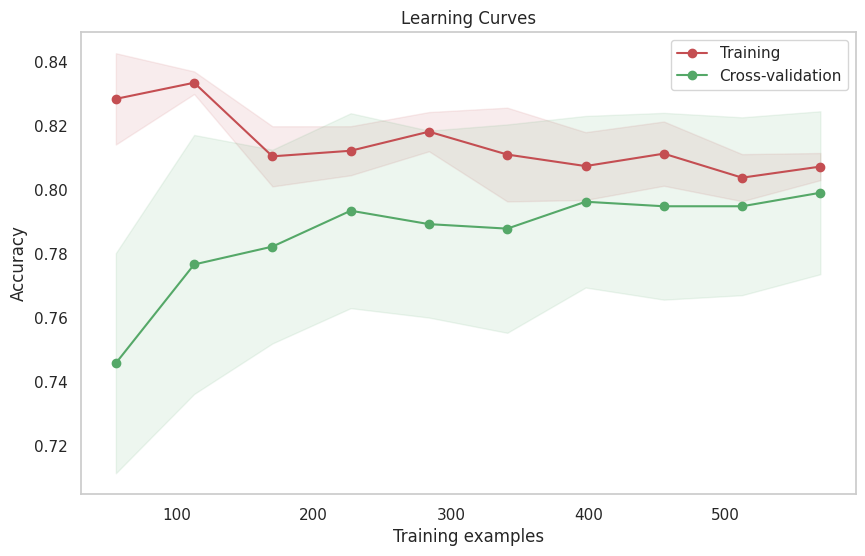

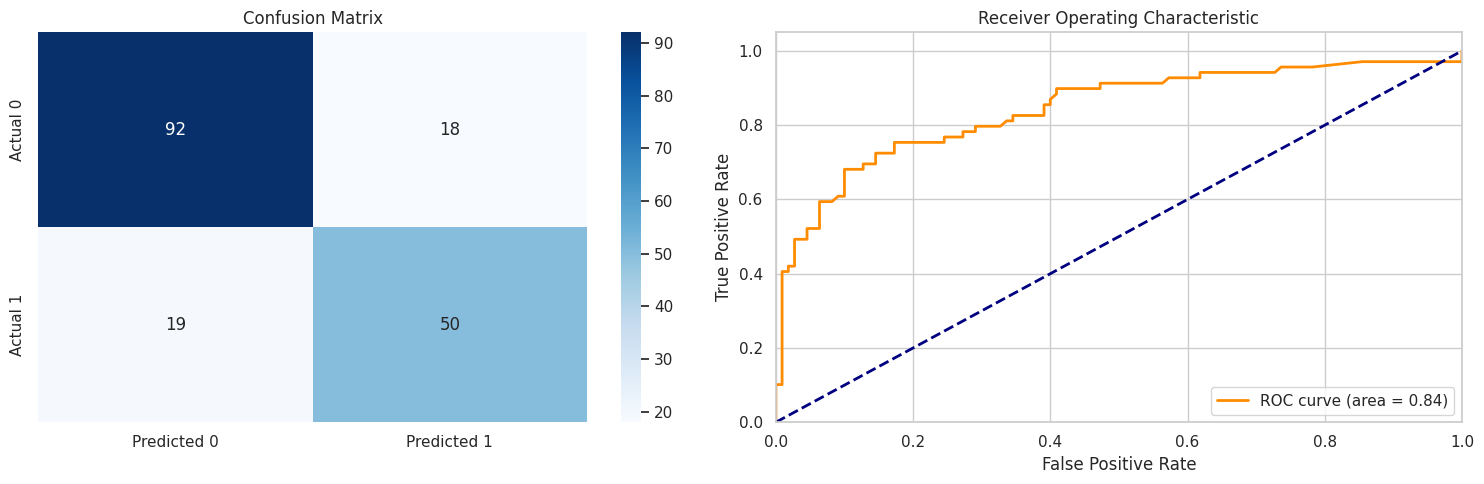

In [91]:
results = evaluate_model(
    pipeline.fit(X_train, y_train), # Fit the pipeline on training data
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    verbose=True,
    cv=5,
    plot_learning_curve=True,
    plot_residuals=True
)